# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 2105344/11490434 [====>.........................] - ETA: 0s

 8396800/11490434 [====================>.........] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 12:55 - loss: 0.6932

  28/1875 [..............................] - ETA: 3s - loss: 0.5406   

  58/1875 [..............................] - ETA: 3s - loss: 0.4577

  91/1875 [>.............................] - ETA: 3s - loss: 0.4128

 124/1875 [>.............................] - ETA: 2s - loss: 0.3853

 153/1875 [=>............................] - ETA: 2s - loss: 0.3679

 189/1875 [==>...........................] - ETA: 2s - loss: 0.3512

 217/1875 [==>...........................] - ETA: 2s - loss: 0.3406

 246/1875 [==>...........................] - ETA: 2s - loss: 0.3311

 276/1875 [===>..........................] - ETA: 2s - loss: 0.3226

 306/1875 [===>..........................] - ETA: 2s - loss: 0.3151

 335/1875 [====>.........................] - ETA: 2s - loss: 0.3086

 365/1875 [====>.........................] - ETA: 2s - loss: 0.3026

 395/1875 [=====>........................] - ETA: 2s - loss: 0.2970

 431/1875 [=====>........................] - ETA: 2s - loss: 0.2910

 454/1875 [======>.......................] - ETA: 2s - loss: 0.2875

 483/1875 [======>.......................] - ETA: 2s - loss: 0.2833

 514/1875 [=======>......................] - ETA: 2s - loss: 0.2791

 545/1875 [=======>......................] - ETA: 2s - loss: 0.2752

 579/1875 [========>.....................] - ETA: 2s - loss: 0.2712

 608/1875 [========>.....................] - ETA: 2s - loss: 0.2680

 635/1875 [=========>....................] - ETA: 2s - loss: 0.2652

 665/1875 [=========>....................] - ETA: 2s - loss: 0.2622

 699/1875 [==========>...................] - ETA: 1s - loss: 0.2591

 729/1875 [==========>...................] - ETA: 1s - loss: 0.2564

 764/1875 [===========>..................] - ETA: 1s - loss: 0.2534

 797/1875 [===========>..................] - ETA: 1s - loss: 0.2508

 832/1875 [============>.................] - ETA: 1s - loss: 0.2482

 862/1875 [============>.................] - ETA: 1s - loss: 0.2460

 893/1875 [=============>................] - ETA: 1s - loss: 0.2438

 930/1875 [=============>................] - ETA: 1s - loss: 0.2414

 959/1875 [==============>...............] - ETA: 1s - loss: 0.2395

 989/1875 [==============>...............] - ETA: 1s - loss: 0.2377

1021/1875 [===============>..............] - ETA: 1s - loss: 0.2358

1055/1875 [===============>..............] - ETA: 1s - loss: 0.2339

1087/1875 [================>.............] - ETA: 1s - loss: 0.2321

1119/1875 [================>.............] - ETA: 1s - loss: 0.2304

1148/1875 [=================>............] - ETA: 1s - loss: 0.2290

1182/1875 [=================>............] - ETA: 1s - loss: 0.2273

1205/1875 [==================>...........] - ETA: 1s - loss: 0.2262

1230/1875 [==================>...........] - ETA: 1s - loss: 0.2250

1258/1875 [===================>..........] - ETA: 1s - loss: 0.2237

1282/1875 [===================>..........] - ETA: 0s - loss: 0.2227

1311/1875 [===================>..........] - ETA: 0s - loss: 0.2214

1337/1875 [====================>.........] - ETA: 0s - loss: 0.2203

1367/1875 [====================>.........] - ETA: 0s - loss: 0.2191

1396/1875 [=====================>........] - ETA: 0s - loss: 0.2179

1428/1875 [=====================>........] - ETA: 0s - loss: 0.2166

1458/1875 [======================>.......] - ETA: 0s - loss: 0.2155

1489/1875 [======================>.......] - ETA: 0s - loss: 0.2143

1518/1875 [=======================>......] - ETA: 0s - loss: 0.2133

1548/1875 [=======================>......] - ETA: 0s - loss: 0.2122

1576/1875 [========================>.....] - ETA: 0s - loss: 0.2113

1603/1875 [========================>.....] - ETA: 0s - loss: 0.2103

1632/1875 [=========================>....] - ETA: 0s - loss: 0.2094

1663/1875 [=========================>....] - ETA: 0s - loss: 0.2084

1693/1875 [==========================>...] - ETA: 0s - loss: 0.2074

1724/1875 [==========================>...] - ETA: 0s - loss: 0.2065

1754/1875 [===========================>..] - ETA: 0s - loss: 0.2055

1785/1875 [===========================>..] - ETA: 0s - loss: 0.2046

1813/1875 [============================>.] - ETA: 0s - loss: 0.2038

1840/1875 [============================>.] - ETA: 0s - loss: 0.2030

1860/1875 [============================>.] - ETA: 0s - loss: 0.2025

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2020


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1055

  31/1875 [..............................] - ETA: 3s - loss: 0.1092

  59/1875 [..............................] - ETA: 3s - loss: 0.1097

  89/1875 [>.............................] - ETA: 3s - loss: 0.1097

 118/1875 [>.............................] - ETA: 3s - loss: 0.1095

 148/1875 [=>............................] - ETA: 2s - loss: 0.1095

 178/1875 [=>............................] - ETA: 2s - loss: 0.1094

 208/1875 [==>...........................] - ETA: 2s - loss: 0.1094

 238/1875 [==>...........................] - ETA: 2s - loss: 0.1093

 267/1875 [===>..........................] - ETA: 2s - loss: 0.1092

 297/1875 [===>..........................] - ETA: 2s - loss: 0.1091

 327/1875 [====>.........................] - ETA: 2s - loss: 0.1091

 356/1875 [====>.........................] - ETA: 2s - loss: 0.1090

 386/1875 [=====>........................] - ETA: 2s - loss: 0.1089

 415/1875 [=====>........................] - ETA: 2s - loss: 0.1088

 445/1875 [======>.......................] - ETA: 2s - loss: 0.1088

 476/1875 [======>.......................] - ETA: 2s - loss: 0.1087

 506/1875 [=======>......................] - ETA: 2s - loss: 0.1086

 536/1875 [=======>......................] - ETA: 2s - loss: 0.1085

 565/1875 [========>.....................] - ETA: 2s - loss: 0.1085

 591/1875 [========>.....................] - ETA: 2s - loss: 0.1084

 620/1875 [========>.....................] - ETA: 2s - loss: 0.1083

 651/1875 [=========>....................] - ETA: 2s - loss: 0.1083

 681/1875 [=========>....................] - ETA: 2s - loss: 0.1082

 707/1875 [==========>...................] - ETA: 2s - loss: 0.1081

 729/1875 [==========>...................] - ETA: 2s - loss: 0.1081

 747/1875 [==========>...................] - ETA: 1s - loss: 0.1080

 766/1875 [===========>..................] - ETA: 1s - loss: 0.1080

 793/1875 [===========>..................] - ETA: 1s - loss: 0.1079

 817/1875 [============>.................] - ETA: 1s - loss: 0.1079

 846/1875 [============>.................] - ETA: 1s - loss: 0.1078

 875/1875 [=============>................] - ETA: 1s - loss: 0.1078

 904/1875 [=============>................] - ETA: 1s - loss: 0.1077

 935/1875 [=============>................] - ETA: 1s - loss: 0.1076

 965/1875 [==============>...............] - ETA: 1s - loss: 0.1076

 995/1875 [==============>...............] - ETA: 1s - loss: 0.1075

1024/1875 [===============>..............] - ETA: 1s - loss: 0.1074

1054/1875 [===============>..............] - ETA: 1s - loss: 0.1074

1083/1875 [================>.............] - ETA: 1s - loss: 0.1073

1112/1875 [================>.............] - ETA: 1s - loss: 0.1073

1141/1875 [=================>............] - ETA: 1s - loss: 0.1072

1171/1875 [=================>............] - ETA: 1s - loss: 0.1072

1200/1875 [==================>...........] - ETA: 1s - loss: 0.1071

1228/1875 [==================>...........] - ETA: 1s - loss: 0.1070

1258/1875 [===================>..........] - ETA: 1s - loss: 0.1070

1288/1875 [===================>..........] - ETA: 1s - loss: 0.1069

1317/1875 [====================>.........] - ETA: 0s - loss: 0.1069

1347/1875 [====================>.........] - ETA: 0s - loss: 0.1068

1377/1875 [=====================>........] - ETA: 0s - loss: 0.1068

1408/1875 [=====================>........] - ETA: 0s - loss: 0.1067

1437/1875 [=====================>........] - ETA: 0s - loss: 0.1067

1466/1875 [======================>.......] - ETA: 0s - loss: 0.1066

1496/1875 [======================>.......] - ETA: 0s - loss: 0.1066

1526/1875 [=======================>......] - ETA: 0s - loss: 0.1065

1556/1875 [=======================>......] - ETA: 0s - loss: 0.1065

1586/1875 [========================>.....] - ETA: 0s - loss: 0.1064

1615/1875 [========================>.....] - ETA: 0s - loss: 0.1064

1640/1875 [=========================>....] - ETA: 0s - loss: 0.1063

1666/1875 [=========================>....] - ETA: 0s - loss: 0.1063

1693/1875 [==========================>...] - ETA: 0s - loss: 0.1062

1723/1875 [==========================>...] - ETA: 0s - loss: 0.1062

1755/1875 [===========================>..] - ETA: 0s - loss: 0.1061

1786/1875 [===========================>..] - ETA: 0s - loss: 0.1061

1817/1875 [============================>.] - ETA: 0s - loss: 0.1060

1848/1875 [============================>.] - ETA: 0s - loss: 0.1060

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1059


Epoch 3/5


   1/1875 [..............................] - ETA: 4s - loss: 0.0956

  31/1875 [..............................] - ETA: 3s - loss: 0.0983

  62/1875 [..............................] - ETA: 3s - loss: 0.0983

  92/1875 [>.............................] - ETA: 3s - loss: 0.0983

 112/1875 [>.............................] - ETA: 3s - loss: 0.0983

 141/1875 [=>............................] - ETA: 3s - loss: 0.0984

 168/1875 [=>............................] - ETA: 3s - loss: 0.0984

 193/1875 [==>...........................] - ETA: 3s - loss: 0.0984

 222/1875 [==>...........................] - ETA: 3s - loss: 0.0984

 245/1875 [==>...........................] - ETA: 3s - loss: 0.0984

 275/1875 [===>..........................] - ETA: 2s - loss: 0.0984

 307/1875 [===>..........................] - ETA: 2s - loss: 0.0984

 337/1875 [====>.........................] - ETA: 2s - loss: 0.0984

 360/1875 [====>.........................] - ETA: 2s - loss: 0.0984

 379/1875 [=====>........................] - ETA: 2s - loss: 0.0984

 403/1875 [=====>........................] - ETA: 2s - loss: 0.0983

 432/1875 [=====>........................] - ETA: 2s - loss: 0.0983

 460/1875 [======>.......................] - ETA: 2s - loss: 0.0983

 491/1875 [======>.......................] - ETA: 2s - loss: 0.0983

 523/1875 [=======>......................] - ETA: 2s - loss: 0.0983

 555/1875 [=======>......................] - ETA: 2s - loss: 0.0983

 585/1875 [========>.....................] - ETA: 2s - loss: 0.0982

 616/1875 [========>.....................] - ETA: 2s - loss: 0.0982

 647/1875 [=========>....................] - ETA: 2s - loss: 0.0982

 678/1875 [=========>....................] - ETA: 2s - loss: 0.0982

 709/1875 [==========>...................] - ETA: 2s - loss: 0.0982

 741/1875 [==========>...................] - ETA: 2s - loss: 0.0982

 773/1875 [===========>..................] - ETA: 1s - loss: 0.0982

 805/1875 [===========>..................] - ETA: 1s - loss: 0.0982

 835/1875 [============>.................] - ETA: 1s - loss: 0.0982

 863/1875 [============>.................] - ETA: 1s - loss: 0.0982

 894/1875 [=============>................] - ETA: 1s - loss: 0.0982

 925/1875 [=============>................] - ETA: 1s - loss: 0.0982

 955/1875 [==============>...............] - ETA: 1s - loss: 0.0982

 982/1875 [==============>...............] - ETA: 1s - loss: 0.0982

1013/1875 [===============>..............] - ETA: 1s - loss: 0.0982

1043/1875 [===============>..............] - ETA: 1s - loss: 0.0981

1073/1875 [================>.............] - ETA: 1s - loss: 0.0981

1104/1875 [================>.............] - ETA: 1s - loss: 0.0981

1134/1875 [=================>............] - ETA: 1s - loss: 0.0981

1164/1875 [=================>............] - ETA: 1s - loss: 0.0981

1194/1875 [==================>...........] - ETA: 1s - loss: 0.0981

1222/1875 [==================>...........] - ETA: 1s - loss: 0.0981

1253/1875 [===================>..........] - ETA: 1s - loss: 0.0981

1284/1875 [===================>..........] - ETA: 1s - loss: 0.0981

1315/1875 [====================>.........] - ETA: 0s - loss: 0.0981

1343/1875 [====================>.........] - ETA: 0s - loss: 0.0981

1371/1875 [====================>.........] - ETA: 0s - loss: 0.0981

1397/1875 [=====================>........] - ETA: 0s - loss: 0.0981

1425/1875 [=====================>........] - ETA: 0s - loss: 0.0980

1454/1875 [======================>.......] - ETA: 0s - loss: 0.0980

1483/1875 [======================>.......] - ETA: 0s - loss: 0.0980

1512/1875 [=======================>......] - ETA: 0s - loss: 0.0980

1538/1875 [=======================>......] - ETA: 0s - loss: 0.0980

1565/1875 [========================>.....] - ETA: 0s - loss: 0.0980

1596/1875 [========================>.....] - ETA: 0s - loss: 0.0980

1627/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1657/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1687/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1717/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1748/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1777/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1806/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1836/1875 [============================>.] - ETA: 0s - loss: 0.0979

1862/1875 [============================>.] - ETA: 0s - loss: 0.0979

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0979


Epoch 4/5
   1/1875 [..............................] - ETA: 6s - loss: 0.0936

  27/1875 [..............................] - ETA: 3s - loss: 0.0956

  58/1875 [..............................] - ETA: 3s - loss: 0.0957

  88/1875 [>.............................] - ETA: 3s - loss: 0.0959

 118/1875 [>.............................] - ETA: 3s - loss: 0.0961

 146/1875 [=>............................] - ETA: 3s - loss: 0.0962

 178/1875 [=>............................] - ETA: 2s - loss: 0.0962

 209/1875 [==>...........................] - ETA: 2s - loss: 0.0962

 241/1875 [==>...........................] - ETA: 2s - loss: 0.0963

 268/1875 [===>..........................] - ETA: 2s - loss: 0.0963

 298/1875 [===>..........................] - ETA: 2s - loss: 0.0963

 329/1875 [====>.........................] - ETA: 2s - loss: 0.0963

 359/1875 [====>.........................] - ETA: 2s - loss: 0.0963

 389/1875 [=====>........................] - ETA: 2s - loss: 0.0963

 419/1875 [=====>........................] - ETA: 2s - loss: 0.0963

 450/1875 [======>.......................] - ETA: 2s - loss: 0.0963

 481/1875 [======>.......................] - ETA: 2s - loss: 0.0963

 509/1875 [=======>......................] - ETA: 2s - loss: 0.0963

 539/1875 [=======>......................] - ETA: 2s - loss: 0.0963

 566/1875 [========>.....................] - ETA: 2s - loss: 0.0963

 590/1875 [========>.....................] - ETA: 2s - loss: 0.0963

 620/1875 [========>.....................] - ETA: 2s - loss: 0.0963

 651/1875 [=========>....................] - ETA: 2s - loss: 0.0963

 680/1875 [=========>....................] - ETA: 2s - loss: 0.0963

 709/1875 [==========>...................] - ETA: 2s - loss: 0.0963

 738/1875 [==========>...................] - ETA: 1s - loss: 0.0963

 767/1875 [===========>..................] - ETA: 1s - loss: 0.0963

 790/1875 [===========>..................] - ETA: 1s - loss: 0.0963

 819/1875 [============>.................] - ETA: 1s - loss: 0.0963

 845/1875 [============>.................] - ETA: 1s - loss: 0.0963

 873/1875 [============>.................] - ETA: 1s - loss: 0.0963

 900/1875 [=============>................] - ETA: 1s - loss: 0.0963

 928/1875 [=============>................] - ETA: 1s - loss: 0.0963

 959/1875 [==============>...............] - ETA: 1s - loss: 0.0963

 989/1875 [==============>...............] - ETA: 1s - loss: 0.0963

1018/1875 [===============>..............] - ETA: 1s - loss: 0.0963

1046/1875 [===============>..............] - ETA: 1s - loss: 0.0963

1076/1875 [================>.............] - ETA: 1s - loss: 0.0962

1105/1875 [================>.............] - ETA: 1s - loss: 0.0962

1128/1875 [=================>............] - ETA: 1s - loss: 0.0962

1159/1875 [=================>............] - ETA: 1s - loss: 0.0962

1189/1875 [==================>...........] - ETA: 1s - loss: 0.0962

1209/1875 [==================>...........] - ETA: 1s - loss: 0.0962

1240/1875 [==================>...........] - ETA: 1s - loss: 0.0962

1265/1875 [===================>..........] - ETA: 1s - loss: 0.0962

1290/1875 [===================>..........] - ETA: 1s - loss: 0.0962

1320/1875 [====================>.........] - ETA: 0s - loss: 0.0962

1350/1875 [====================>.........] - ETA: 0s - loss: 0.0962

1379/1875 [=====================>........] - ETA: 0s - loss: 0.0962

1406/1875 [=====================>........] - ETA: 0s - loss: 0.0962

1434/1875 [=====================>........] - ETA: 0s - loss: 0.0962

1459/1875 [======================>.......] - ETA: 0s - loss: 0.0962

1488/1875 [======================>.......] - ETA: 0s - loss: 0.0962

1517/1875 [=======================>......] - ETA: 0s - loss: 0.0962

1546/1875 [=======================>......] - ETA: 0s - loss: 0.0962

1575/1875 [========================>.....] - ETA: 0s - loss: 0.0962

1605/1875 [========================>.....] - ETA: 0s - loss: 0.0962

1635/1875 [=========================>....] - ETA: 0s - loss: 0.0962

1663/1875 [=========================>....] - ETA: 0s - loss: 0.0962

1692/1875 [==========================>...] - ETA: 0s - loss: 0.0962

1722/1875 [==========================>...] - ETA: 0s - loss: 0.0962

1752/1875 [===========================>..] - ETA: 0s - loss: 0.0962

1782/1875 [===========================>..] - ETA: 0s - loss: 0.0962

1812/1875 [===========================>..] - ETA: 0s - loss: 0.0961

1842/1875 [============================>.] - ETA: 0s - loss: 0.0961

1872/1875 [============================>.] - ETA: 0s - loss: 0.0961

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0961


Epoch 5/5
   1/1875 [..............................] - ETA: 4s - loss: 0.1073

  30/1875 [..............................] - ETA: 3s - loss: 0.0972

  57/1875 [..............................] - ETA: 3s - loss: 0.0966

  84/1875 [>.............................] - ETA: 3s - loss: 0.0962

 114/1875 [>.............................] - ETA: 3s - loss: 0.0960

 143/1875 [=>............................] - ETA: 3s - loss: 0.0959

 172/1875 [=>............................] - ETA: 3s - loss: 0.0958

 202/1875 [==>...........................] - ETA: 2s - loss: 0.0958

 231/1875 [==>...........................] - ETA: 2s - loss: 0.0957

 261/1875 [===>..........................] - ETA: 2s - loss: 0.0957

 290/1875 [===>..........................] - ETA: 2s - loss: 0.0957

 320/1875 [====>.........................] - ETA: 2s - loss: 0.0957

 350/1875 [====>.........................] - ETA: 2s - loss: 0.0957

 378/1875 [=====>........................] - ETA: 2s - loss: 0.0957

 407/1875 [=====>........................] - ETA: 2s - loss: 0.0957

 434/1875 [=====>........................] - ETA: 2s - loss: 0.0957

 458/1875 [======>.......................] - ETA: 2s - loss: 0.0957

 487/1875 [======>.......................] - ETA: 2s - loss: 0.0957

 516/1875 [=======>......................] - ETA: 2s - loss: 0.0956

 544/1875 [=======>......................] - ETA: 2s - loss: 0.0956

 572/1875 [========>.....................] - ETA: 2s - loss: 0.0956

 602/1875 [========>.....................] - ETA: 2s - loss: 0.0956

 631/1875 [=========>....................] - ETA: 2s - loss: 0.0956

 659/1875 [=========>....................] - ETA: 2s - loss: 0.0956

 687/1875 [=========>....................] - ETA: 2s - loss: 0.0956

 716/1875 [==========>...................] - ETA: 2s - loss: 0.0956

 745/1875 [==========>...................] - ETA: 2s - loss: 0.0956

 775/1875 [===========>..................] - ETA: 1s - loss: 0.0956

 804/1875 [===========>..................] - ETA: 1s - loss: 0.0956

 833/1875 [============>.................] - ETA: 1s - loss: 0.0956

 863/1875 [============>.................] - ETA: 1s - loss: 0.0956

 892/1875 [=============>................] - ETA: 1s - loss: 0.0956

 916/1875 [=============>................] - ETA: 1s - loss: 0.0956

 941/1875 [==============>...............] - ETA: 1s - loss: 0.0956

 970/1875 [==============>...............] - ETA: 1s - loss: 0.0956

 994/1875 [==============>...............] - ETA: 1s - loss: 0.0956

1021/1875 [===============>..............] - ETA: 1s - loss: 0.0956

1048/1875 [===============>..............] - ETA: 1s - loss: 0.0956

1077/1875 [================>.............] - ETA: 1s - loss: 0.0956

1106/1875 [================>.............] - ETA: 1s - loss: 0.0956

1134/1875 [=================>............] - ETA: 1s - loss: 0.0956

1163/1875 [=================>............] - ETA: 1s - loss: 0.0956

1191/1875 [==================>...........] - ETA: 1s - loss: 0.0956

1215/1875 [==================>...........] - ETA: 1s - loss: 0.0955

1244/1875 [==================>...........] - ETA: 1s - loss: 0.0955

1272/1875 [===================>..........] - ETA: 1s - loss: 0.0955

1301/1875 [===================>..........] - ETA: 1s - loss: 0.0955

1330/1875 [====================>.........] - ETA: 0s - loss: 0.0955

1356/1875 [====================>.........] - ETA: 0s - loss: 0.0955

1386/1875 [=====================>........] - ETA: 0s - loss: 0.0955

1409/1875 [=====================>........] - ETA: 0s - loss: 0.0955

1437/1875 [=====================>........] - ETA: 0s - loss: 0.0955

1463/1875 [======================>.......] - ETA: 0s - loss: 0.0955

1493/1875 [======================>.......] - ETA: 0s - loss: 0.0955

1523/1875 [=======================>......] - ETA: 0s - loss: 0.0955

1551/1875 [=======================>......] - ETA: 0s - loss: 0.0955

1580/1875 [========================>.....] - ETA: 0s - loss: 0.0955

1609/1875 [========================>.....] - ETA: 0s - loss: 0.0955

1638/1875 [=========================>....] - ETA: 0s - loss: 0.0955

1667/1875 [=========================>....] - ETA: 0s - loss: 0.0955

1695/1875 [==========================>...] - ETA: 0s - loss: 0.0955

1724/1875 [==========================>...] - ETA: 0s - loss: 0.0955

1752/1875 [===========================>..] - ETA: 0s - loss: 0.0955

1780/1875 [===========================>..] - ETA: 0s - loss: 0.0955

1810/1875 [===========================>..] - ETA: 0s - loss: 0.0955

1841/1875 [============================>.] - ETA: 0s - loss: 0.0955

1867/1875 [============================>.] - ETA: 0s - loss: 0.0955

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0955


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

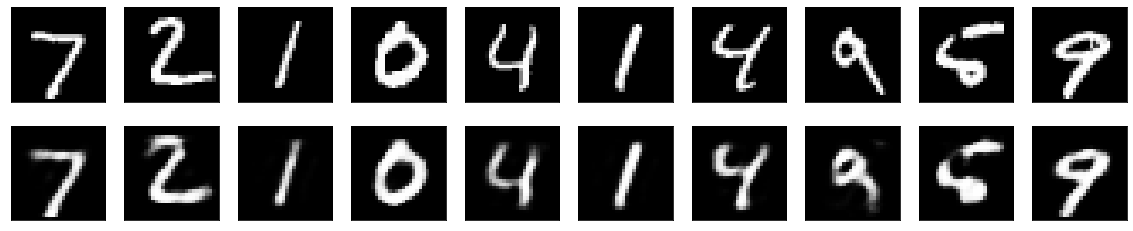

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
